# Voice conversion prototyping

with GMMs; Arctic corpus

Speakers p299 and p248

In [1]:
# open data
from os.path import join, expanduser
DATA_ROOT = join(expanduser("~"), "Documents/em_lct/UoM/thesis/data/", "arctic")
!ls $DATA_ROOT

cmu_us_awb_arctic cmu_us_clb_arctic


In [2]:
# nnmnkwii imports taken from example notebook on VC
%pylab inline
rcParams["figure.figsize"] = (16,5)

from nnmnkwii.datasets import PaddedFileSourceDataset
from nnmnkwii.datasets.cmu_arctic import CMUArcticWavFileDataSource
from nnmnkwii.preprocessing.alignment import DTWAligner
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames, delta_features
from nnmnkwii.util import apply_each2d_trim
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG

from os import listdir
from os.path import basename, splitext, join, splitext, isdir
import sys
import time

import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import pyworld
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import IPython
from IPython.display import Audio

Populating the interactive namespace from numpy and matplotlib


/Users/kennylino/.local/share/virtualenvs/thesis-W2ZHkp3l/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
fs = 16000
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
order = 24
frame_period = 5
hop_length = int(fs * (frame_period * 0.001))
max_files = 30 # number of utterances to be used.
test_size = 0.33
use_delta = True

if use_delta:
    windows = [
        (0, 0, np.array([1.0])),
        (1, 1, np.array([-0.5, 0.0, 0.5])),
        (1, 1, np.array([1.0, -2.0, 1.0])),
    ]
else:
    windows = [
        (0, 0, np.array([1.0])),
    ]

In [4]:
class MyFileDataSource(CMUArcticWavFileDataSource):
    def __init__(self, *args, **kwargs):
        super(MyFileDataSource, self).__init__(*args, **kwargs)
        self.test_paths = None

    def collect_files(self):
        paths = super(
            MyFileDataSource, self).collect_files()
        paths_train, paths_test = train_test_split(
            paths, test_size=test_size, random_state=42)

        # keep paths for later testing
        self.test_paths = paths_test

        return paths_train

    def collect_features(self, path):
        x, frame_sample = librosa.load(path, sr=fs, dtype=float64)
        f0, timeaxis = pyworld.dio(x, frame_sample, frame_period=frame_period)
        f0 = pyworld.stonemask(x, f0, timeaxis, frame_sample)
        spectrogram = pyworld.cheaptrick(x, f0, timeaxis, frame_sample)
        spectrogram = trim_zeros_frames(spectrogram)
        mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
        return mc

In [5]:
src_speaker = MyFileDataSource(data_root=DATA_ROOT, speakers=["awb"], max_files=max_files) # This is actually speaker TNI from Arctic L2
tgt_speaker = MyFileDataSource(data_root=DATA_ROOT, speakers=["clb"], max_files=max_files) 

In [6]:
# convert training sets into arrays
X = PaddedFileSourceDataset(src_speaker, 1200).asarray()
Y = PaddedFileSourceDataset(tgt_speaker, 1200).asarray()
print(X.shape)
print(Y.shape) 
# shape = (13 training audios, 2800 frames, 25 features per frame)

(20, 1200, 25)
(20, 1200, 25)


In [7]:
src_speaker.test_paths

['/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0028.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0016.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0024.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0018.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0009.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0010.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0029.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0025.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0013.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0001.wav']

In [8]:
tgt_speaker.test_paths

['/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0028.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0016.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0024.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0018.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0009.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0010.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0029.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0025.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0013.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0001.wav']

In [9]:
# Plotting util
def plot_parallel(x,y):
    figure(figsize=(16,7))
    subplot(2,1,1)
    librosa.display.specshow(trim_zeros_frames(x).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()
    subplot(2,1,2)
    librosa.display.specshow(trim_zeros_frames(y).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()

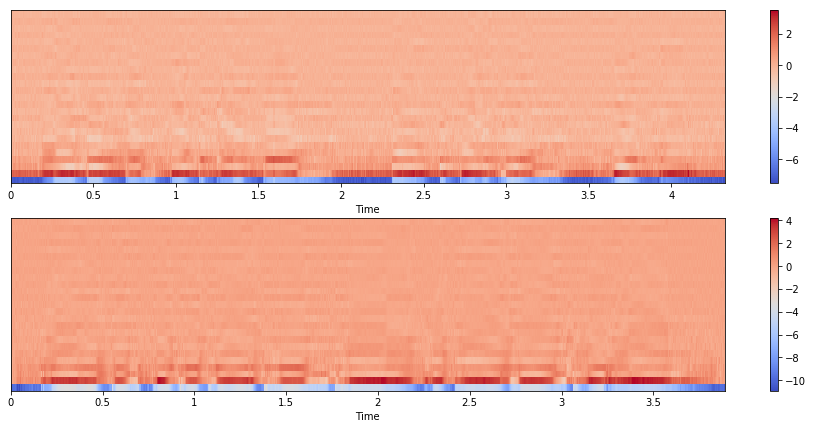

In [10]:
idx = 6 # any 
plot_parallel(X[idx],Y[idx])

In [11]:
# Alignment
X_aligned, Y_aligned = DTWAligner(verbose=0, dist=melcd).transform((X, Y))

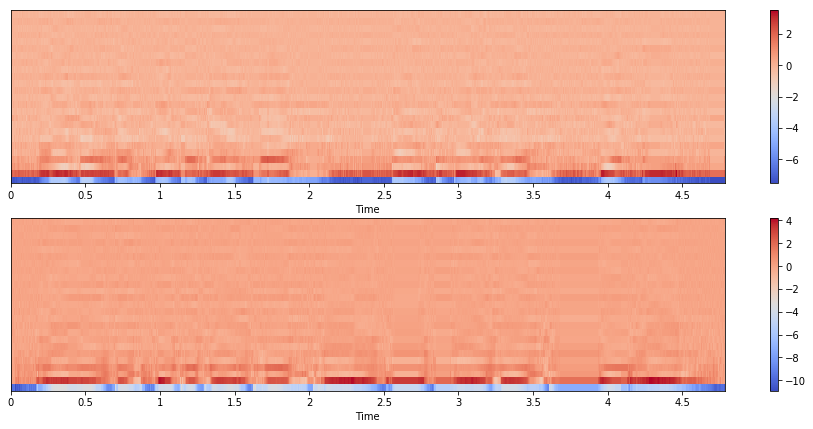

In [12]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

In [13]:
# Drop 1st (power) dimension
X_aligned, Y_aligned = X_aligned[:, :, 1:], Y_aligned[:, :, 1:]

In [14]:
static_dim = X_aligned.shape[-1]
if use_delta:
    X_aligned = apply_each2d_trim(delta_features, X_aligned, windows)
    Y_aligned = apply_each2d_trim(delta_features, Y_aligned, windows)

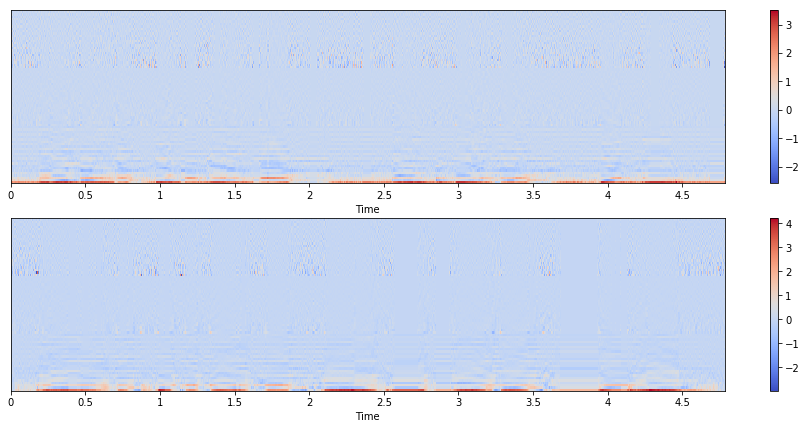

In [15]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

### Finally, we get joint feature matrix

As we represent features in numpy arrays, it's very easy to combine them.

In [18]:
XY = np.concatenate((X_aligned, Y_aligned), axis=-1).reshape(-1, X_aligned.shape[-1]*2)
print(XY.shape)

(25320, 144)


Note that we padded zeros to data. Removes zeros frames to speed-up training. 

In [19]:
XY = remove_zeros_frames(XY)
print(XY.shape)

(17040, 144)


## GMM training

In [20]:
gmm = GaussianMixture(
    n_components=64, covariance_type="full", max_iter=100, verbose=1)

%time gmm.fit(XY)

Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
CPU times: user 4min 34s, sys: 47.3 s, total: 5min 22s
Wall time: 1min 22s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=64, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

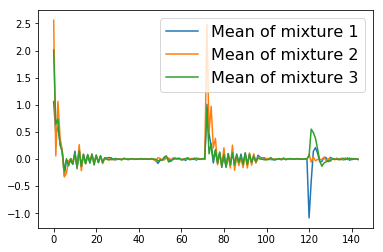

In [21]:
for k in range(3):
    plot(gmm.means_[k], linewidth=1.5, label="Mean of mixture {}".format(k+1))
legend(prop={"size": 16})

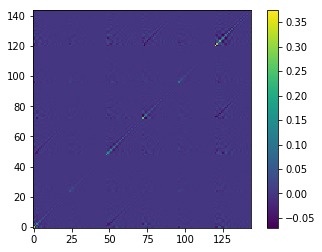

In [22]:
imshow(gmm.covariances_[0], origin="bottom left")
colorbar()

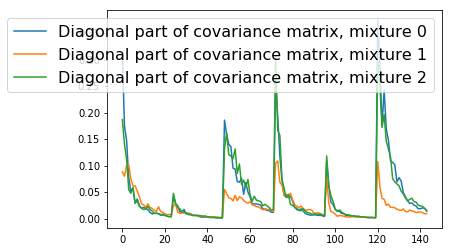

In [23]:
for k in range(3):
    plot(np.diag(gmm.covariances_[k]), linewidth=1.5, 
         label="Diagonal part of covariance matrix, mixture {}".format(k))
legend(prop={"size": 16})

In [24]:
def test_one_utt(src_path, tgt_path, disable_mlpg=False, diffvc=True):
    # GMM-based parameter generation is provided by the library in `baseline` module
    if disable_mlpg:
        # Force disable MLPG
        paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=diffvc)
    else:
        paramgen = MLPG(gmm, windows=windows, diff=diffvc)

    x, frame_sample = librosa.load(src_path, sr=fs, dtype=float64)
    f0, timeaxis = pyworld.dio(x, frame_sample, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, frame_sample)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, frame_sample)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, frame_sample)

    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    if use_delta:
        mc = delta_features(mc, windows)
    mc = paramgen.transform(mc)
    if disable_mlpg and mc.shape[-1] != static_dim:
        mc = mc[:,:static_dim]
    assert mc.shape[-1] == static_dim
    mc = np.hstack((c0[:, None], mc))
    if diffvc:
        mc[:, 0] = 0 # remove power coefficients
        engine = Synthesizer(MLSADF(order=order, alpha=alpha), hopsize=hop_length)
        b = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)
        waveform = engine.synthesis(x, b)
    else:
        spectrogram = pysptk.mc2sp(
            mc.astype(np.float64), alpha=alpha, fftlen=fftlen)
        waveform = pyworld.synthesize(
            f0, spectrogram, aperiodicity, frame_sample, frame_period)
        
    return waveform

Compare results with [this](http://people.tamu.edu/~guanlong.zhao/icassp18_demo.html)

In [25]:
for i, (src_path, tgt_path) in enumerate(zip(src_speaker.test_paths, tgt_speaker.test_paths)):
    print("{}-th sample".format(i+1))
    wo_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=True)
    w_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=False)
    src, _ = librosa.load(src_path, sr=fs, dtype=float64)
    tgt, _ = librosa.load(tgt_path, sr=fs, dtype=float64)
    
    print("Source:", basename(src_path))
    IPython.display.display(Audio(src, rate=fs))
    print("Target:", basename(tgt_path))
    IPython.display.display(Audio(tgt, rate=fs))
    print("w/o MLPG")
    IPython.display.display(Audio(wo_MLPG, rate=fs))
    print("w/ MLPG")
    IPython.display.display(Audio(w_MLPG, rate=fs))

1-th sample
Source: arctic_a0028.wav


Target: arctic_a0028.wav


w/o MLPG


w/ MLPG


2-th sample
Source: arctic_a0016.wav


Target: arctic_a0016.wav


w/o MLPG


w/ MLPG


3-th sample
Source: arctic_a0024.wav


Target: arctic_a0024.wav


w/o MLPG


w/ MLPG


4-th sample
Source: arctic_a0018.wav


Target: arctic_a0018.wav


w/o MLPG


w/ MLPG


5-th sample
Source: arctic_a0009.wav


Target: arctic_a0009.wav


w/o MLPG


w/ MLPG


6-th sample
Source: arctic_a0010.wav


Target: arctic_a0010.wav


w/o MLPG


w/ MLPG


7-th sample
Source: arctic_a0029.wav


Target: arctic_a0029.wav


w/o MLPG


w/ MLPG


8-th sample
Source: arctic_a0025.wav


Target: arctic_a0025.wav


w/o MLPG


w/ MLPG


9-th sample
Source: arctic_a0013.wav


Target: arctic_a0013.wav


w/o MLPG


w/ MLPG


10-th sample
Source: arctic_a0001.wav


Target: arctic_a0001.wav


w/o MLPG


w/ MLPG
